# **Twitter Sentiment Analysis**


Hi everyone! This is my second kernel, focus on sentiment classification. I have been learning through different resources , which I am gonna leave at the end.

I am still improving some things like the unbalanced dataset, that I am going to include, by means of different resampling methods. So, please any feedback is welcome! :)

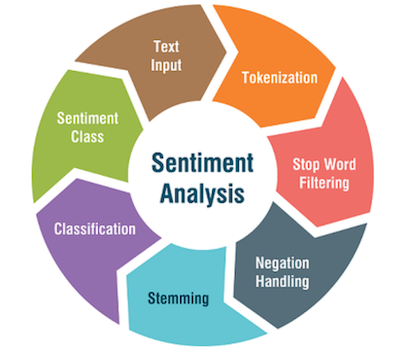

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

# Library to work with emojis
!pip install emoji

import numpy as np
import emoji
import string
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os

# Standard plotly imports
import chart_studio.plotly as py
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import plotly.express as px
import shapely
import plotly.graph_objects as go

from plotly.subplots import make_subplots
from plotly.offline import iplot, init_notebook_mode
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [ ]:
data = pd.read_csv("/kaggle/input/twitter-airline-sentiment/Tweets.csv",sep=",")
data.head()

# **1. BASIC ANALISYS**


In [ ]:
tweets = data[["airline","text","airline_sentiment"]]  
tweets.head()

In [ ]:
print("The dataset has {0} rows and {1} columns".format(tweets.shape[0],tweets.shape[1]))

In [ ]:
tweets.dtypes

In [ ]:
tweets.isnull().sum().sort_values(ascending=False)

# **2.VISUALIZATION**

In [ ]:
# Grouping by sentiment and air companies
tweets_group=data.groupby(["airline_sentiment","airline"])["airline"].count()


## Pie chart
labels = tweets.airline_sentiment.value_counts().index
values = tweets.airline_sentiment.value_counts().values
fig_pie = go.Figure(data=[go.Pie(labels=labels, values=values)],layout=go.Layout(title=go.layout.Title(text="Total number of sentiments per category")))
fig_pie.show()


## Barplot
air_company=tweets_group.index.levels[1]
sentiment=tweets_group.index.levels[0]
fig_bar = go.Figure(go.Bar(x=air_company, y=tweets_group["negative"], name=sentiment[0]),layout=go.Layout(title=go.layout.Title(text="Sentiment per company")))
fig_bar.add_trace(go.Bar(x=air_company, y=tweets_group["neutral"], name=sentiment[1]))
fig_bar.add_trace(go.Bar(x=air_company, y=tweets_group["positive"], name=sentiment[2]))
fig_bar.update_layout(title="Number of each sentiment",barmode='group', xaxis={'categoryorder':'category ascending'})


As we can observe, the class labels are unbalanced and this is something that we should keep in mind later.

# **3.CLEANING DATA**

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

# Class to clean the Tweets
class CleanText(BaseEstimator, TransformerMixin):
 
  # Removing URLs and hastag symbols and URLs
    def removeURL_MentionsSymbol_HastagSymbol(self,tweet):
        self.tweet_clean_mention = re.sub(r"@[a-zA-Z0-9]+|\#[a-zA-Z0-9]+","",str(tweet))
        self.tweet_clean_url = re.sub(r"(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b","", self.tweet_clean_mention, flags=re.MULTILINE).strip()
        return self.tweet_clean_url

  # Transforming emojis into text
    def removeEmoji(self,text):
        self.tweet = text
        for token in self.tweet:
            if token in emoji.UNICODE_EMOJI:
                self.tweet = self.tweet.replace(token,emoji.demojize(token))
        return self.tweet

  # Removing digits
    def removeDigits(self,tweet):
        return re.sub(r"[0-9]","",tweet)
  
  # Removing symbols which are not ASCII
    def clean_ascii(self,text):
        return ''.join(i for i in text if ord(i) < 128)

  # Transforming text into lowercase
    def lower_case(self,tweet):
        return tweet.lower()

    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        clean_X = X.apply(self.removeURL_MentionsSymbol_HastagSymbol).apply(self.removeEmoji).apply(self.removeDigits).apply(self.clean_ascii).apply(self.lower_case)
        return clean_X
    
    def get_params(self, deep=True):
        return {}      

# **4.TOKENIZATION AND VECTORIZATION**

In [ ]:
# Spacy library for nlp
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

In [ ]:
# Load English tokenizer, tagger, parser, NER and word vectors
nlp=English()

# List of StopWords
stop_words = spacy.lang.en.stop_words.STOP_WORDS

# List with punctuations 
punctuations = string.punctuation


In [ ]:
# Function to tokenize the tweets
def spacy_tokenizer(tweet):
  
  # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = nlp(tweet)

  # Lemmatizing each token and converting each token into lowercase
    mytokens = [word.lemma_.strip() for word in mytokens if word.lemma_ != "-PRON-" ]

  # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

  # return preprocessed list of tokens
    return mytokens

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF
tfidf_vector = TfidfVectorizer(tokenizer=spacy_tokenizer)

# **5.CLASSIFIERS AND SPLITTING DATA INTO TRAINING AND TEST SETS**


In [ ]:
from sklearn.svm import LinearSVC  
from sklearn.model_selection import train_test_split

svm = LinearSVC(C=1,loss="hinge")

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(tweets.text,tweets.airline_sentiment,test_size=0.33,random_state=42)

In [ ]:
X_train.head()

# **6.CREATING THE PIPELINE**

In [ ]:
from sklearn.pipeline import Pipeline

# Defining the pipeline:
#   1. Cleaning text
#   2. Vectorizen
#   3. Classifying with logistic regression

pipe_tweets = Pipeline([("clean",CleanText()),
                        ("vectorizer",tfidf_vector),
                        ("svm",svm)])


# **7.TRAINING THE MODEL**

In [ ]:
pipe_tweets.fit(X_train,y_train)

# **8. EVALUATING THE MODEL**

In [ ]:
from sklearn import metrics
from sklearn.metrics import classification_report

# Predicting with a test dataset
y_predicted = pipe_tweets.predict(X_test)

# Model Accuracy
print("SVM Accuracy:",metrics.accuracy_score(y_test, y_predicted))
print("SVM Precision:",metrics.precision_score(y_test, y_predicted,average="macro"))
print("SVM Recall:",metrics.recall_score(y_test, y_predicted,average="macro"))


# Classification Report

print("\n"+classification_report(y_test, y_predicted, target_names=["negative","neutral","positive"], digits=4))

# 9 . REFERENCES:
 * Spacy course: https://course.spacy.io/chapter1
 * Sentiment classificatione exampler with spacy: https://www.dataquest.io/blog/tutorial-text-classification-in-python-using-spacy/
 * Emoji python library: https://pypi.org/project/emoji/
 * Plotly library: https://plot.ly/python/pie-charts/
 * Sentiment analysis planification: https://www.datacamp.com/community/tutorials/simplifying-sentiment-analysis-python